### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [ ]:
# %pip install --upgrade transformers datasets accelerate deepspeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets

### Load data and model

In [ ]:
qqp = datasets.load_dataset('SetFit/qqp');
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

Repo card metadata block was not found. Setting CardData to empty.




Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [ ]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

### Tokenize the data

In [ ]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

In [ ]:
qqp_preprocessed = qqp.map(preprocess_function, batched=True)

In [ ]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

[101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136,  ...


### Task 1: evaluation (1 point)

We randomly chose a model trained on QQP - but is it any good?

One way to measure this is with validation accuracy - which is what you will implement next.

Here's the interface to help you do that:

In [ ]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=False, collate_fn=transformers.default_data_collator
)

In [ ]:
for batch in val_loader:
     # here be your training code
     break
print("Sample batch:", batch)

with torch.no_grad():
  predicted = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask'],
      token_type_ids=batch['token_type_ids']
  )

print('\nPrediction (probs):', torch.softmax(predicted.logits, dim=1).data.numpy())

Sample batch: {'labels': tensor([0]), 'idx': tensor([0]), 'input_ids': tensor([[  101,  2009,  1132,  2170,   118,  4038,  1177,  2712,   136,   102,
          2009,  1132,  1117, 10224,  4724,  1177,  2712,   136,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,   

__Your task__ is to measure the validation accuracy of your model.
Doing so naively may take several hours. Please make sure you use the following optimizations:

- run the model on GPU with no_grad
- using batch size larger than 1
- use optimize data loader with num_workers > 1
- (optional) use [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


In [ ]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=64, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=2)

In [ ]:
model = model.to('cuda')

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
y_true, y_pred = [], []

for batch in tqdm(val_loader):
    with torch.no_grad():
        predicted_probs = model(input_ids=batch['input_ids'].cuda(),
                                attention_mask=batch['attention_mask'].cuda(),
                                token_type_ids=batch['token_type_ids'].cuda())
        predictions = torch.argmax(predicted_probs['logits'], -1)
        y_pred.extend(predictions.cpu())
        y_true.extend(batch['labels'])

accuracy = accuracy_score(y_true, y_pred)

In [ ]:
accuracy

In [ ]:
assert 0.9 < accuracy < 0.91

### Task 2: train the model (4 points)

For this task, you have two options:

__Option A:__ fine-tune your own model. You are free to choose any model __except for the original BERT.__ We recommend [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). Better yet, choose the best model based on public benchmarks (e.g. [GLUE](https://gluebenchmark.com/)).

You can write the training code manually or use transformers.Trainer (see [this example](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Please make sure that your model's accuracy is at least __comparable__ with the above example for BERT.


__Option B:__ compare at least 3 pre-finetuned models (in addition to the above BERT model). For each model, report (1) its accuracy, (2) its speed, measured in samples per second in your hardware setup and (3) its size in megabytes. Please take care to compare models in equal setting, e.g. same CPU / GPU. Compile your results into a table and write a short (~half-page on top of a table) report, summarizing your findings.

#### **Попробуем дообучить только голову модели, остальные веса заморозим**

In [ ]:
# Imports
import wandb
from tqdm import tqdm

In [ ]:
qqp.cleanup_cache_files()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
EPOCHS = 1
LR = 1e-3
BATCH_SIZE = 256

In [ ]:
model_name = "microsoft/deberta-v3-base"
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

In [ ]:
for name, param in model.named_parameters():
  if name not in ['pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'pooler.dense.bias']:
      param.requires_grad = False

In [ ]:
qqp_preprocessed = qqp.map(preprocess_function, batched=True)

train_set = qqp_preprocessed['train']
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=2)

val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=2)

In [ ]:
model = model.to('cuda')
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import accuracy_score

def compute_accuracy():
    y_true, y_pred = [], []

    for batch in val_loader:
        with torch.no_grad():
            predicted_probs = model(input_ids=batch['input_ids'].cuda(),
                                    attention_mask=batch['attention_mask'].cuda(),
                                    token_type_ids=batch['token_type_ids'].cuda())
            predictions = torch.argmax(predicted_probs['logits'], -1)
            y_pred.extend(predictions.cpu())
            y_true.extend(batch['labels'])

    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [ ]:
config = dict(
    epochs=EPOCHS,
    lr=LR,
    batch_size=BATCH_SIZE,
    freeze=True)

wandb.init(project='nlp_hw05', config=config)

with tqdm(total=len(train_loader)) as pbar:
    for i in range(EPOCHS):
        model.train()
        for j, batch in enumerate(train_loader):
            predicted = model(
                input_ids=batch['input_ids'].cuda(),
                attention_mask=batch['attention_mask'].cuda(),
                token_type_ids=batch['token_type_ids'].cuda()
            )

            opt.zero_grad()
            loss = loss_fn(predicted['logits'].cpu(), batch['labels'])
            wandb.log({"loss": loss})
            loss.backward()
            opt.step()
            pbar.update(1)
            torch.cuda.empty_cache()
            if not i % 100:
                torch.save(model, '/content/drive/MyDrive/models/deberta.pt')

Графи обучения:

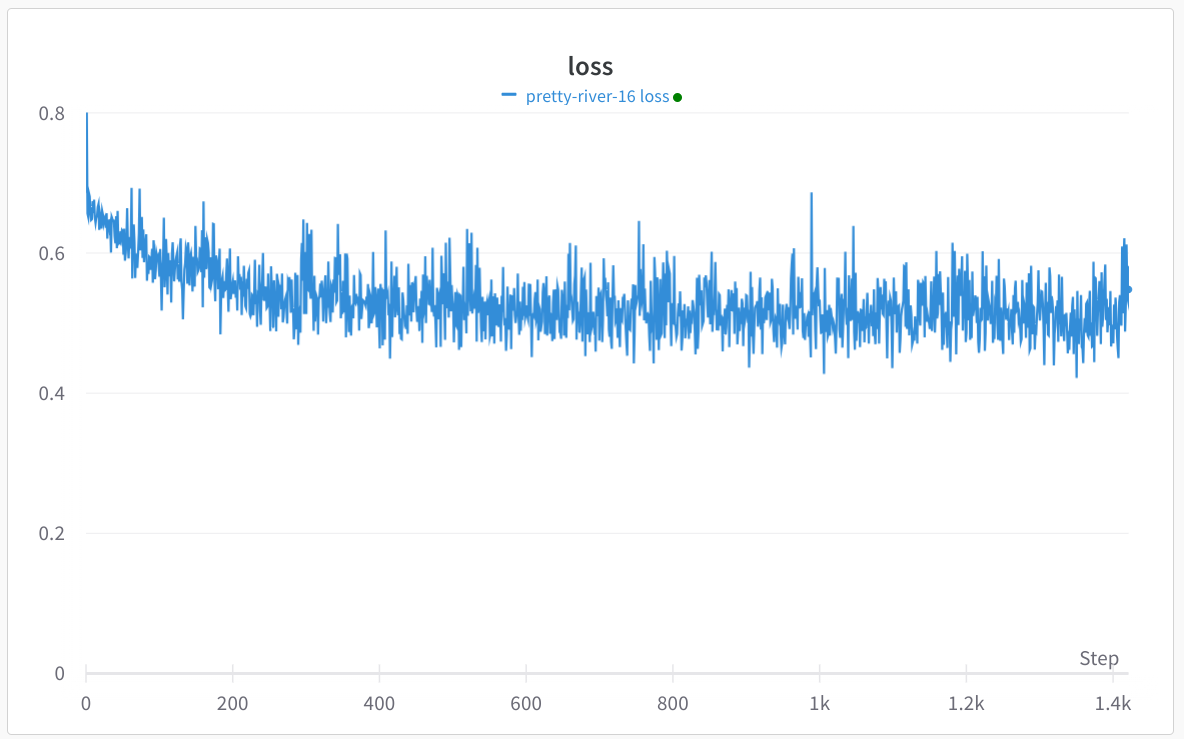

In [ ]:
model.eval()
acc = compute_accuracy()
wandb.log({"val_acc": acc})
print(f'accuracy on val_set = {acc:.3f}')

100%|██████████| 158/158 [01:32<00:00,  1.71it/s]


accuracy on val_set = 0.793


#### **Попробуем дообучить всю модель**

In [ ]:
BATCH_SIZE = 32
LR = 2e-5

In [ ]:
qqp.cleanup_cache_files()

model_name = "microsoft/deberta-v3-base"
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

qqp_preprocessed = qqp.map(preprocess_function, batched=True)
train_set = qqp_preprocessed['train']
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=2)

val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=2)

In [ ]:
# !pip install evaluate
import evaluate
from scipy.special import softmax
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(softmax(logits, axis=-1), axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="deberta_trainer",
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=1000,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=1,
    overwrite_output_dir=True,
    logging_strategy='steps',
    logging_steps=50,
    logging_dir="trainer",
    dataloader_num_workers=2,
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=qqp_preprocessed['train'],
    eval_dataset=qqp_preprocessed['validation'],
    compute_metrics=compute_metrics
)

trainer.train()

wandb: Currently logged in as: rollineea. Use `wandb login --relogin` to force relogin


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
1000,0.286700,0.350585,0.854415
2000,0.284600,0.260049,0.888993
3000,0.270200,0.252430,0.892506
4000,0.227600,0.247601,0.897428
5000,0.233900,0.232890,0.902449
6000,0.234400,0.233187,0.902770
7000,0.241400,0.223357,0.907346
8000,0.240300,0.225667,0.907074


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fas

Step,Training Loss,Validation Loss,Accuracy
1000,0.286700,0.350585,0.854415
2000,0.284600,0.260049,0.888993
3000,0.270200,0.252430,0.892506
4000,0.227600,0.247601,0.897428
5000,0.233900,0.232890,0.902449
6000,0.234400,0.233187,0.902770
7000,0.241400,0.223357,0.907346
8000,0.240300,0.225667,0.907074
9000,0.241300,0.215638,0.910908
10000,0.220700,0.213034,0.912021


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=11371, training_loss=0.24895813060240846, metrics={'train_runtime': 4281.3138, 'train_samples_per_second': 84.985, 'train_steps_per_second': 2.656, 'total_flos': 2.393340547233485e+16, 'train_loss': 0.24895813060240846, 'epoch': 1.0})

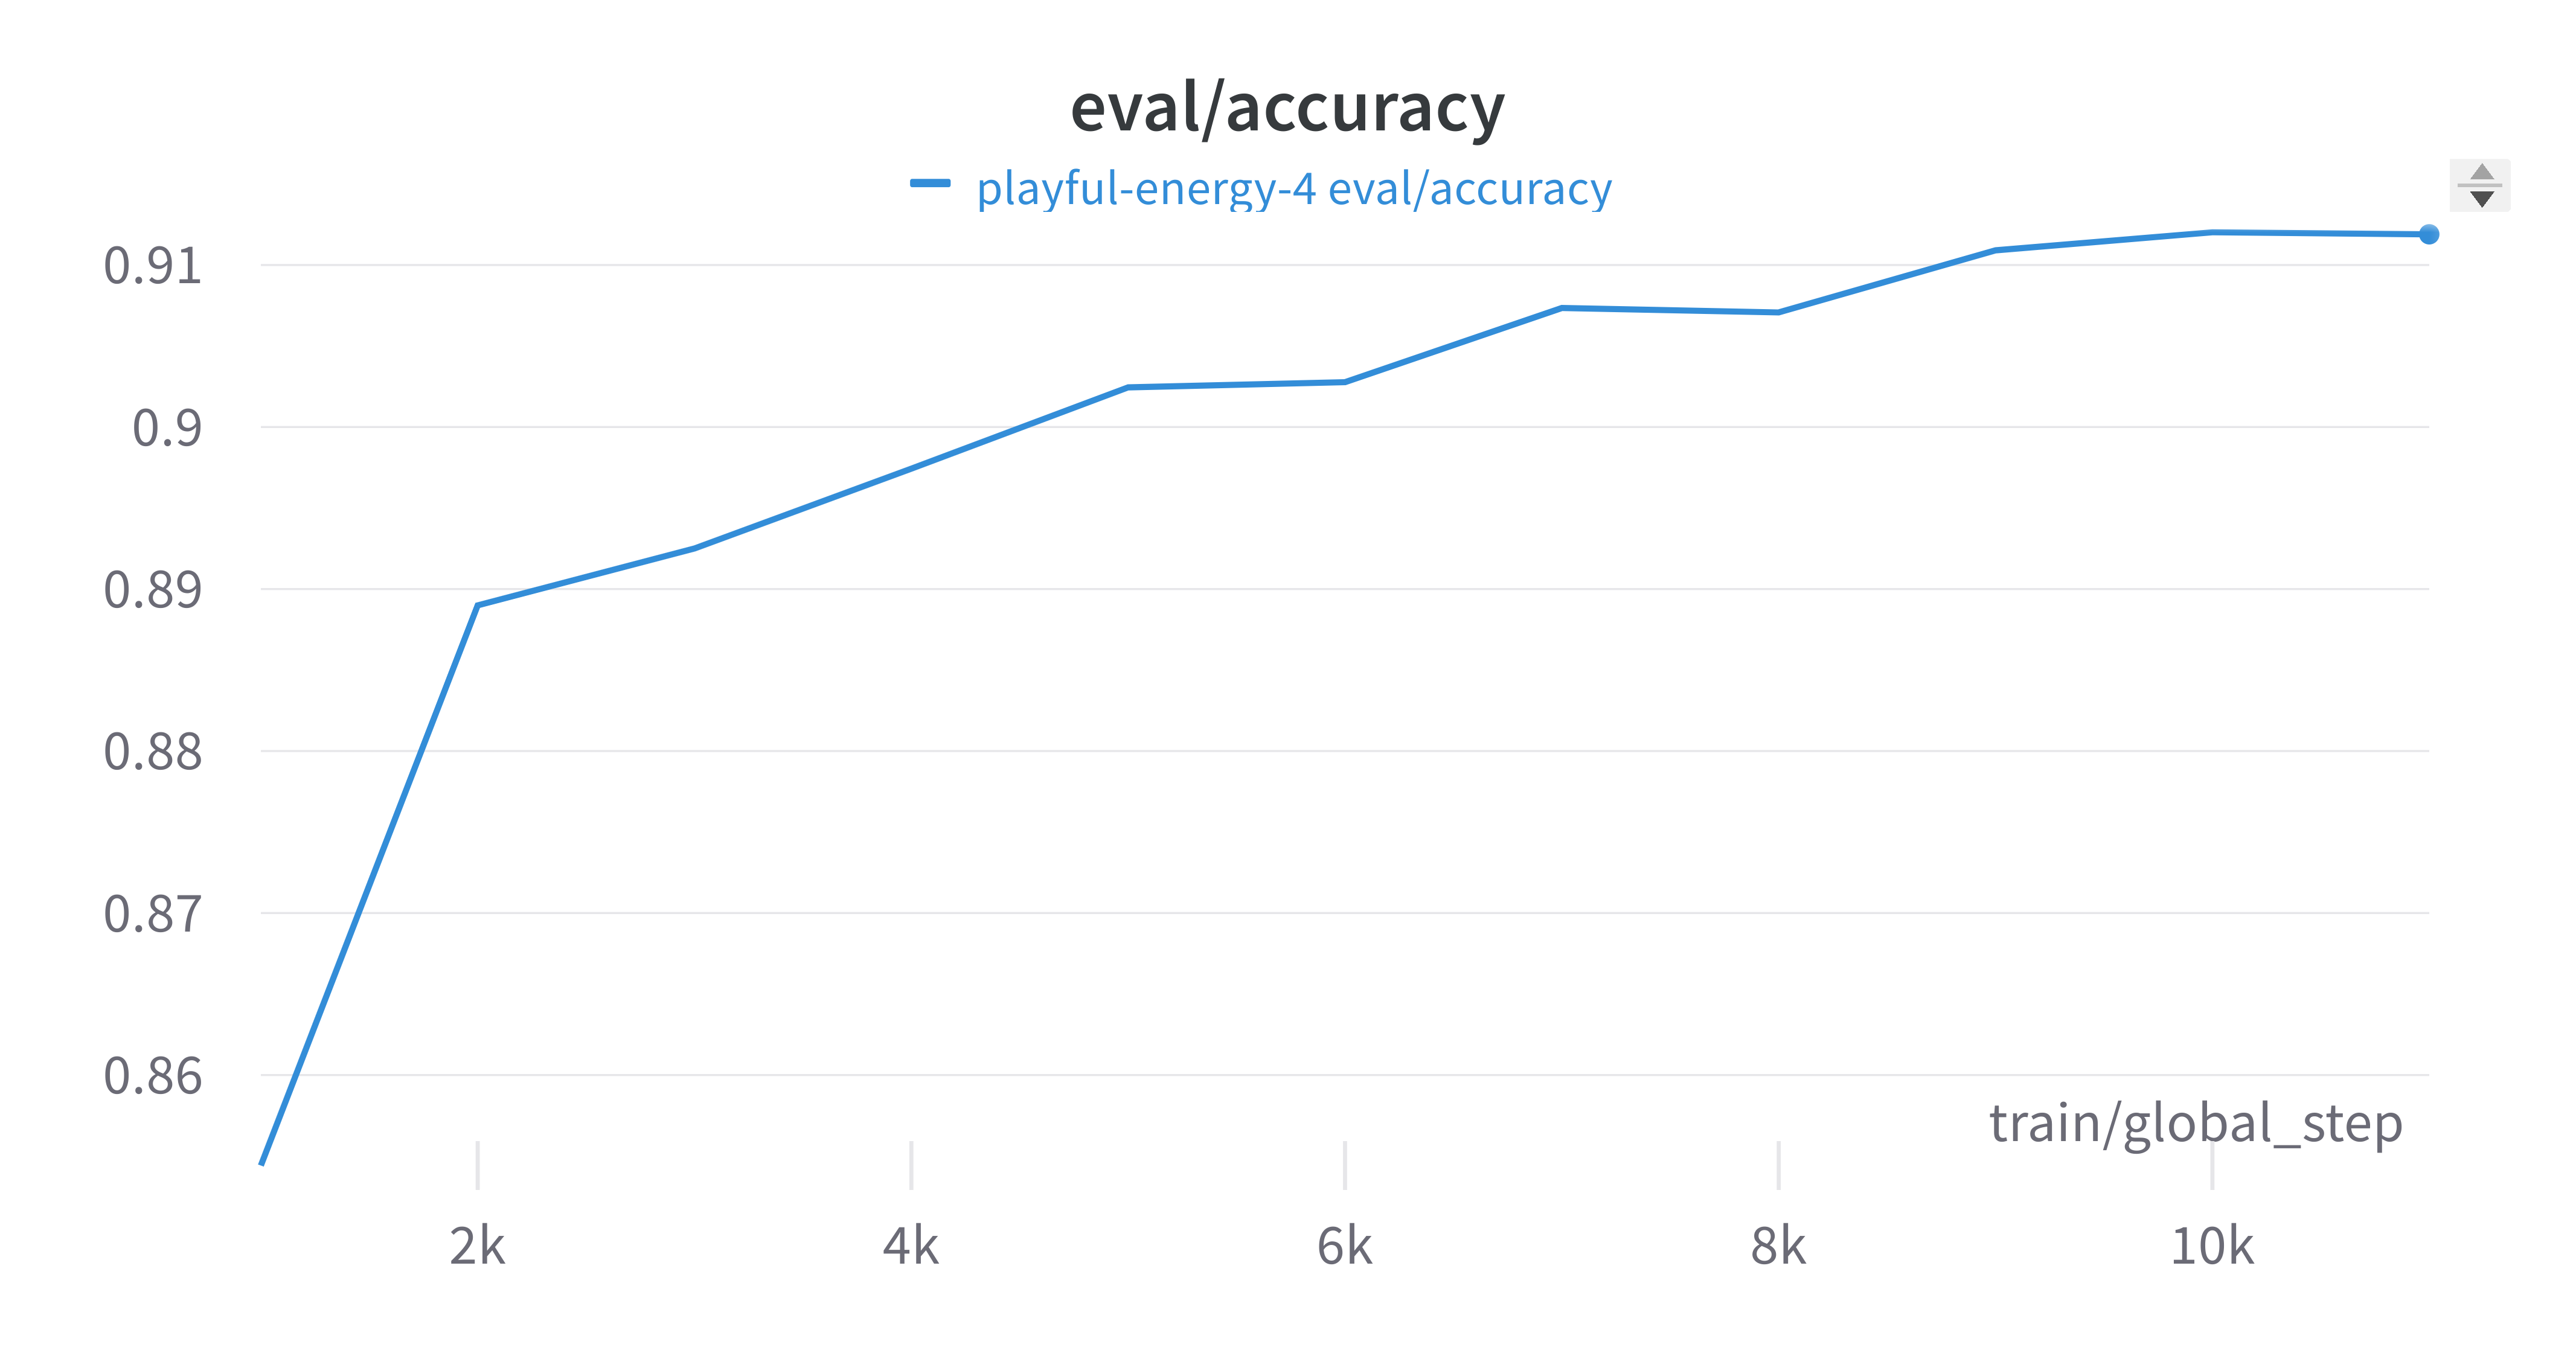

### Task 3: try the full pipeline (1 point)

Finally, it is time to use your model to find duplicate questions.
Please implement a function that takes a question and finds top-5 potential duplicates in the training set. For now, it is fine if your function is slow, as long as it yields correct results.

Showcase how your function works with at least 5 examples.

In [ ]:
# pip install sentencepiece
import sentencepiece
from tqdm import tqdm
BATCH_SIZE = 256
MAX_LENGTH = 128

In [ ]:
model = transformers.AutoModelForSequenceClassification.from_pretrained("drive/MyDrive/deberta_trainer/checkpoint-11371/").to('cuda')
tokenizer = transformers.AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
all_questions = list(set([q['text1'] for q in qqp['train']] + [q['text2'] for q in qqp['train']]))

In [ ]:
class QDataset(torch.utils.data.Dataset):
    def __init__(self, question, all_questions):
        self.question = question
        self.all_questions = all_questions
    def __getitem__(self, idx):
        return tokenizer(self.question, self.all_questions[idx], padding='max_length', max_length=MAX_LENGTH, truncation=True)
    def __len__(self):
      return len(self.all_questions)

In [ ]:
def find_duplicates(model, question, all_questions, topn=5):
    dataset = QDataset(question, all_questions)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=2)
    probs = []

    model.eval()
    with torch.no_grad():
      for batch in tqdm(loader):
          predicted = model(
                  input_ids=batch['input_ids'].cuda(),
                  attention_mask=batch['attention_mask'].cuda(),
                  token_type_ids=batch['token_type_ids'].cuda()
              )
          probs.append(torch.softmax(predicted['logits'], dim=-1)[:, 1])
    probs = torch.cat(probs).detach().cpu()

    probs, ids = torch.sort(probs, descending=True)
    probs, ids = probs[:topn].numpy(), ids[:topn].numpy()
    questions = [all_questions[i] for i in ids]

    print(f"Top {topn} duplicates for question: {question}\n")
    for i in range(len(ids)):
        print(f"{i + 1} score: {probs[i]:.3f}, question: {all_questions[i]}")

In [ ]:
question = 'How is the life of a math student? Could you describe your own experiences?'

In [ ]:
find_duplicates(model, question, all_questions)

 13%|█▎        | 248/1930 [08:43<59:20,  2.12s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c31deed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 13%|█▎        | 249/1930 [08:45<59:12,  2.11s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c31deed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/tor

Top 5 duplicates for question: How is the life of a math student? Could you describe your own experiences?

1 score: 0.981, question: Who is this this guy in the picture?
2 score: 0.753, question: What is the difference between an IT product and IT service company?
3 score: 0.478, question: What course I have to do to be a UX/UI designer?
4 score: 0.301, question: My eye doctor has given a number for long -2.75 and for short sight I need not wear glasses. I intend to use contact lens. How to go about?
5 score: 0.232, question: Kolkata, West Bengal, India: What does one miss out on by not being a Bengali?


__Bonus:__ for bonus points, try to find a way to run the function faster than just passing over all questions in a loop. For isntance, you can form a short-list of potential candidates using a cheaper method, and then run your tranformer on that short list. If you opted for this solution, please keep both the original implementation and the optimized one - and explain briefly what is the difference there.